<img src="https://i.imgur.com/BzoPAKJ.png" width="100%" height="30%">

## Fashion MNIST - A beginner's guide.. 📝

*This notebook covers basic steps, a beginner should take while approaching an image classification problem.<br>
We begin by building a baseline Neural Network model, then progressively adapts techniques to improve the model evaluation metric.*

**While approaching any machine learning task, there are 3 key steps to be defined**:

1. ```Understanding the problem/data```
2. ```Defining the model```
3. ```Choosing the evaluation metric```

*Building a baseline model gives a solid working framework for the solution. It then becomes much easier to adapt other techniques and iterate throught the framework.*

## Dataset 💽

*Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. <br>Each example is a 28x28 grayscale image, associated with a label from 10 classes.*

📖 **Data description**
 - ```Each row is a separate image```
 - ```Column 1 is the class label.```
 - ```Remaining columns are pixel numbers (784 total).```
 - ```Each value is the darkness of the pixel (1 to 255)```
 
🏷️ **Labels**
 - ```0``` T-shirt/top
 - ```1``` Trouser
 - ```2``` Pullover
 - ```3``` Dress
 - ```4``` Coat
 - ```5``` Sandal
 - ```6``` Shirt
 - ```7``` Sneaker
 - ```8``` Bag
 - ```9``` Ankle boot
 
🎯 **Goal:** To build an algorithm to accurately predict the clothing category from images. 

**How to read this notebook?** 
I have added a brief explanation of the data transformation and modelling techniques used in a **Why**❓ section before each code block. <br>This will help understand the need for such a transformation. 
In addition, I have tried to explain each line of code with comments next to the syntax.

In [1]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
#%matplotlib inline

#### Helper Functions

In [2]:
def predict_n_validate_individual_samples(index):
    plt.figure()
    plt.imshow(test_x[index].reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()
    print("Actual Value: ", class_names[test_y[index]])
    print("Model Prediction: ", class_names[np.argmax(model.predict(test_x[index].reshape(1, 28, 28, 1)))])
    
# code to visualize individual sample
def plot_sample(df, index):
    plt.figure()
    plt.imshow(df[index].reshape(28, 28))
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [4]:
train_images = pd.read_csv(r'C:\Users\pspar\Downloads\archive (2)\fashion-mnist_train.csv')
test_images = pd.read_csv(r'C:\Users\pspar\Downloads\archive (2)\fashion-mnist_test.csv')

print(train_images.shape)
print(test_images.shape)

(60000, 785)
(10000, 785)


**Check the distribution of target column in the dataset**

**Why**❓

- *Checking the distribution of the target column helps us better understand the data. In real world, datasets are often skewed, that is, <br>there will be an ```unequal distribution of samples``` which adversely affects the learning and model performance. In such cases, <br>the model will tend to overfit to a particular set of samples. Techniques like undersampling, oversampling, smote-analysis, etc. <br>help handle such scenarios, however we will not discuss it in detail.*
- *It also helps define ```the evaluation metric``` to be considered while analyzing the performance.*

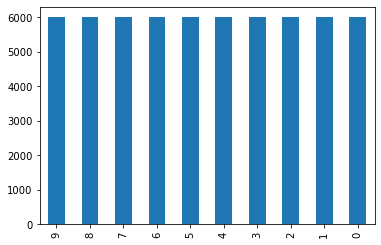

In [5]:
train_images.label.value_counts().plot(kind='bar')
plt.show()

✔️The above plot shows that the data is well sampled. There is equal distribution of each class.
Thus we can choose ```Accuracy``` as the model evaluation metric.

**Evaluation Metric:** Accuracy
 $$Accuracy = \frac{1}{n_{samples}}\Sigma_{i=0}^{n_{samples}-1}1{\Big({y_i - \hat{y_i}}\Big)}$$
 where 
> * $y_i$ : original value
> * $\hat{y_i}$ : predicted value
> * $n$ : number of rows in the test data

In [6]:
# Separate out the label column from the training features
# This step makes it easier to handle the data for training 

# code below using python slicing
# [:, 1:] - means - all rows, all columns except first column
# .values converts the pandas dataframe into a numpy array

train_x = train_images.iloc[:, 1:].values
train_y = train_images.label.values

test_x = test_images.iloc[:, 1:].values
test_y = test_images.label.values

In [7]:
# Assign the class names to a list
# This helps better understand the class of predicted as well as the
# displayed image

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

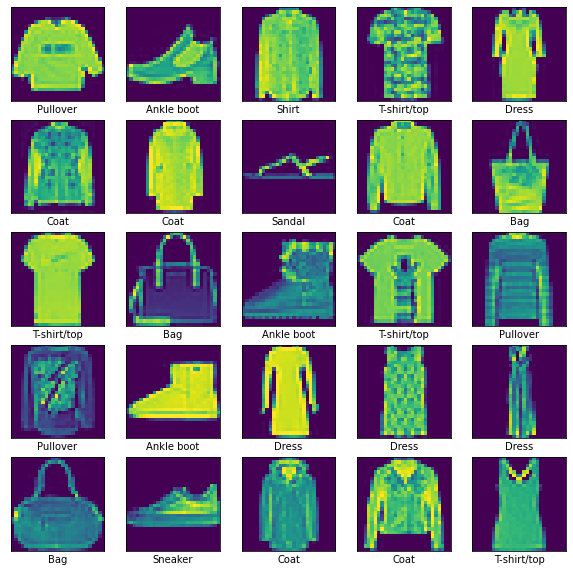

In [8]:
# Code for visualizing 25 images in the dataset
# It is always important to frequently visualize and validate the data before training the model

plt.figure(figsize=(10,10)) # create an empty figure
for i in range(25): # loop through first 25 rows
    plt.subplot(5,5,i+1) # create a 5x5 subplot and iterate through each
    plt.xticks([]) # removing the ticks on x-axis
    plt.yticks([]) # removing the ticks on y-axis
    plt.grid(False) # disabling the grid
    
    # before plotting the image
    # the image is reshape into 28x28 shape
    # this is because the original data is a single 1d array with 784 columns 
    # each indicating a pixel value
    
    plt.imshow(train_x[i].reshape(28, 28)) 
    plt.xlabel(class_names[train_y[i]]) # assigning the labels
plt.show() 

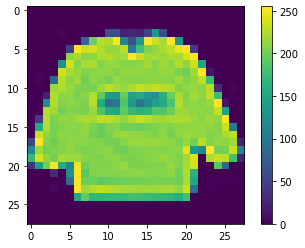

In [9]:
# Using the helper function defined earlier
plot_sample(train_x, 0)

**Rescale/Normalize the images**

**Why**❓

- *The above figure shows a colorbar going from 0 to 255. The highest value is 255. It's always a best approach to rescale/normalize the data before feeding it to neural networks.<br> Normalizing the data, speeds up learning and leads to faster convergence of the learning algorithm.*

Sample image after Scaling


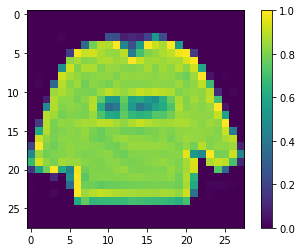

In [10]:
train_x = train_x / 255.0
test_x = test_x / 255.0

print("Sample image after Scaling")
plot_sample(train_x, 0)

✔️ The scaled image, has a mean close to 0.

**Creating a validation set**

**Why**❓

- *While training a machine learning model, it is a good approach to evaluate the model side-by-side against a set of unseen data.<br> This set used for validation is called a validation set. Here we consider 20% of the training data as the validation set. <br>There are techniques like K-Fold, Stratified K-fold.etc which can be used to create a batch of training and validation samples*

In [11]:
# using the train_test_split function from scikit-learn
# specifying a test size of 20%
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

## Baseline Model - Neural Network (2 layers) 🧠

*It's always good to start with a simple base model. This ensures that we have a working framework which can later be *modified to improve the evaluation metric.* 
*At later stages:*
 - *Changes to the data include implementing data augmentation techniques*
 - *Changes to the model include trying out different model architectures by changing the layers*
 
**For the baseline model** *we will be using a Flatten layer and two Dense layers. With a softmax activation at the final layer as we need the output probability of each class.*
 - ```Flatten layer``` - *transforms the image to a full connected 1-d array of 28x28 = 784 pixels*
 - ```Dense Layer``` - *Fully connected layer*

In [12]:
# keras Sequential allows us to stack different layers of 
# the model architecture
model = Sequential([
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax') # 10 units as we have 10 output classes, softmax activation as we need the probability output
])

- *After defining the model we have to compile the model.*
- *Optimizer decides the technique to be used for adjusting the weights and bias of the learning algorithm.*
- *Here we use an ```ADAM(Adaptive Moment Estimation)``` optimizer.*
- *loss = ```SparseCategoricalCrossentropy``` - calculates cross entropy loss between predicted and actual values*

In [13]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Reshape the data before fitting the model**

**Why**❓

- *The model expects a ```4D Tensor``` as input*
- *Hence we have to reshape the training data.*
- *At present the training data has 784 columns each containing the pixel values*
- *By reshaping we convert it to a format = (#of samples, img_rows, img_cols, #of channels)*
- *i.e. (60000, 28, 28, 1)*

In [14]:
# the model metrics and training performance is captured 
# in variable model_history
model1_history = model.fit(train_x.reshape(train_x.shape[0], 28, 28, 1), 
                    train_y, 
                    epochs=10,
                    validation_data=(val_x.reshape(val_x.shape[0], 28, 28, 1), val_y),
                   )

Epoch 1/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.6892 - accuracy: 0.7817 - val_loss: 1.6503 - val_accuracy: 0.8152
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.6274 - accuracy: 0.8366 - val_loss: 1.6232 - val_accuracy: 0.8417
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.6138 - accuracy: 0.8489 - val_loss: 1.6136 - val_accuracy: 0.8480
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.6080 - accuracy: 0.8542 - val_loss: 1.6054 - val_accuracy: 0.8576
Epoch 5/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.6022 - accuracy: 0.8603 - val_loss: 1.6099 - val_accuracy: 0.8522
Epoch 6/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.5954 - accuracy: 0.8669 - val_loss: 1.5994 - val_accuracy: 0.8623
Epoch 7/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.5936 - accuracy: 0.8689 - val_loss: 1.6053 - val_accuracy:

- *The baseline model has 90% training set accuracy and 88% validation set accuracy*
- *This accuracy for a simple network with just 10 epochs of training is considerably good. However, let's add more layers and try improving the model*

In [15]:
# Plotting the model architecture
#plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


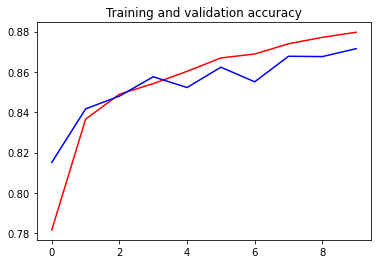

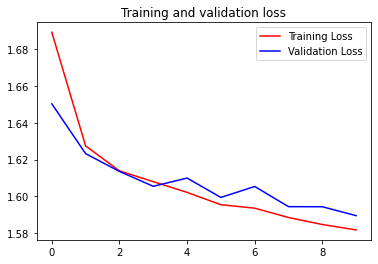

In [16]:
acc = model1_history.history['accuracy']
val_acc = model1_history.history['val_accuracy']
loss = model1_history.history['loss']
val_loss = model1_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
# Evalution on the test set
test_loss, test_acc = model.evaluate(test_x.reshape(test_x.shape[0], 28, 28, 1), test_y)
print('\nTest accuracy:', test_acc)

313/313 [==============================] - 0s 1ms/step - loss: 1.5889 - accuracy: 0.8727

Test accuracy: 0.8726999759674072


### Model Inferencing 🎯

- *It is important to validate the predictions of the model*
- *This acts as a feedback loop, in tuning the model.*

Choose random samples and compare the predicted value with the ground truth.

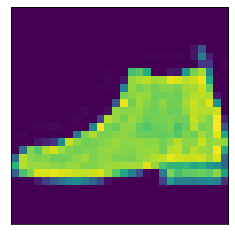

Actual Value:  Ankle boot
Model Prediction:  Ankle boot


In [18]:
predict_n_validate_individual_samples(100)

## Let's add a Convolution Layer, Pooling Layer and Dropout 🧠

*To improve the model we can add a Convolution layer and Pooling Layer* 
 
**For the baseline model
 - ```Convolution layer``` - *Applies mathematical convolution over image and thus helps the neural network focus on specific features in the images.*
 - ```Pooling Layer``` - *Pooling helps reduce the number of trainable parameters in the image, without compromising the information contained in each pixel. <br>There are different approaches to Pooling, we will use MaxPooling where each output will be MAX of a particular region.*
 - ```Dropout``` - *Dropout eliminates random nodes and acts as a regularizer. Adding a dropout layer can help reduce overfitting.*

In [19]:
model2 = Sequential([
    Conv2D(filters=32, kernel_size=3),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax') 
])

model2.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model2_history = model2.fit(train_x.reshape(train_x.shape[0], 28, 28, 1), 
                    train_y, 
                    epochs=10,
                    validation_data=(val_x.reshape(val_x.shape[0], 28, 28, 1), val_y),
                   )

Epoch 1/10
1500/1500 [==============================] - 20s 14ms/step - loss: 1.7109 - accuracy: 0.7529 - val_loss: 1.6589 - val_accuracy: 0.8035
Epoch 2/10
1500/1500 [==============================] - 21s 14ms/step - loss: 1.6554 - accuracy: 0.8065 - val_loss: 1.6490 - val_accuracy: 0.8128
Epoch 3/10
1500/1500 [==============================] - 20s 13ms/step - loss: 1.6426 - accuracy: 0.8190 - val_loss: 1.6371 - val_accuracy: 0.8246
Epoch 4/10
1500/1500 [==============================] - 20s 13ms/step - loss: 1.6367 - accuracy: 0.8247 - val_loss: 1.6335 - val_accuracy: 0.8285
Epoch 5/10
1500/1500 [==============================] - 20s 13ms/step - loss: 1.6295 - accuracy: 0.8321 - val_loss: 1.6336 - val_accuracy: 0.8279
Epoch 6/10
1500/1500 [==============================] - 19s 13ms/step - loss: 1.6254 - accuracy: 0.8355 - val_loss: 1.6310 - val_accuracy: 0.8295
Epoch 7/10
1500/1500 [==============================] - 19s 13ms/step - loss: 1.6214 - accuracy: 0.8399 - val_loss: 1.6272 -

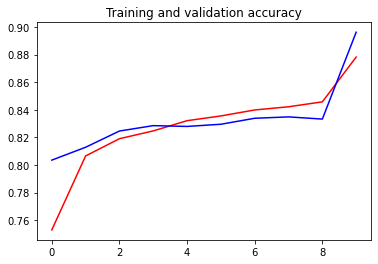

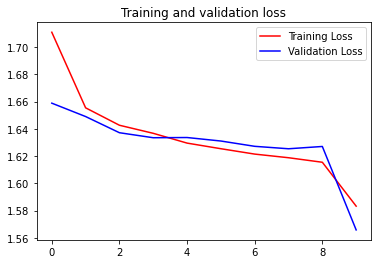

In [20]:
acc = model2_history.history['accuracy']
val_acc = model2_history.history['val_accuracy']
loss = model2_history.history['loss']
val_loss = model2_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
# Evalution on the test set
test_loss, test_acc = model2.evaluate(test_x.reshape(test_x.shape[0], 28, 28, 1), test_y)
print('\nTest accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 1.5631 - accuracy: 0.8978

Test accuracy: 0.8978000283241272
